In [2]:
# https://keras.io/examples/generative/vq_vae/

In [20]:
# pip install tensorflow_probability
# pip install --user tensorflow
# !pip install tensorflow --upgrade

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_probability as tfp

In [4]:
tf.__version__

'2.10.0'

In [2]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [36]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [37]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQu  (None, 7, 7, 16)          1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48913 (191.07 KB)
Trainable params: 48913 (191.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [64]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [65]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 14s 30ms/step - loss: 1.8254 - reconstruction_loss: 0.3801 - vqvae_loss: 1.0939
Epoch 2/15
469/469 [==============================] - 14s 29ms/step - loss: 1.8008 - reconstruction_loss: 0.1496 - vqvae_loss: 1.6399
Epoch 3/15
469/469 [==============================] - 14s 29ms/step - loss: 0.8995 - reconstruction_loss: 0.1206 - vqvae_loss: 0.7741
Epoch 4/15
469/469 [==============================] - 14s 29ms/step - loss: 0.6177 - reconstruction_loss: 0.1002 - vqvae_loss: 0.5128
Epoch 5/15
469/469 [==============================] - 14s 29ms/step - loss: 0.4253 - reconstruction_loss: 0.0857 - vqvae_loss: 0.3369
Epoch 6/15
469/469 [==============================] - 14s 29ms/step - loss: 0.3493 - reconstruction_loss: 0.0770 - vqvae_loss: 0.2709
Epoch 7/15
469/469 [==============================] - 14s 29ms/step - loss: 0.3169 - reconstruction_loss: 0.0716 - vqvae_loss: 0.2440
Epoch 8/15
469/469 [==============================] - 13s 29ms

### ADJUSTING WEIGHT OF VQ LOSS

In [51]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            vq_loss_weight = 0.5  # Experiment with different values
            total_loss = reconstruction_loss + vq_loss_weight * sum(self.vqvae.losses)


        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [58]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [53]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 14s 30ms/step - loss: 2.3213 - reconstruction_loss: 0.3888 - vqvae_loss: 3.1614
Epoch 2/15
469/469 [==============================] - 14s 29ms/step - loss: 2.9218 - reconstruction_loss: 0.1700 - vqvae_loss: 5.4887
Epoch 3/15
469/469 [==============================] - 14s 29ms/step - loss: 1.6176 - reconstruction_loss: 0.1473 - vqvae_loss: 2.9331
Epoch 4/15
469/469 [==============================] - 14s 31ms/step - loss: 1.1127 - reconstruction_loss: 0.1221 - vqvae_loss: 1.9670
Epoch 5/15
469/469 [==============================] - 14s 29ms/step - loss: 0.5927 - reconstruction_loss: 0.1016 - vqvae_loss: 0.9756
Epoch 6/15
469/469 [==============================] - 14s 30ms/step - loss: 0.4663 - reconstruction_loss: 0.0898 - vqvae_loss: 0.7473
Epoch 7/15
469/469 [==============================] - 14s 30ms/step - loss: 0.4031 - reconstruction_loss: 0.0822 - vqvae_loss: 0.6399
Epoch 8/15
469/469 [==============================] - 14s 30ms

### Experimenting with beta=1.5

In [57]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            vq_loss_weight = 1.5  # Experiment with different values
            total_loss = reconstruction_loss + vq_loss_weight * sum(self.vqvae.losses)


        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [59]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 14s 29ms/step - loss: 2.0559 - reconstruction_loss: 0.3299 - vqvae_loss: 0.9440
Epoch 2/15
469/469 [==============================] - 14s 29ms/step - loss: 1.2945 - reconstruction_loss: 0.1388 - vqvae_loss: 0.7640
Epoch 3/15
469/469 [==============================] - 14s 29ms/step - loss: 0.6602 - reconstruction_loss: 0.1135 - vqvae_loss: 0.3618
Epoch 4/15
469/469 [==============================] - 14s 29ms/step - loss: 0.4822 - reconstruction_loss: 0.0950 - vqvae_loss: 0.2550
Epoch 5/15
469/469 [==============================] - 14s 29ms/step - loss: 0.3649 - reconstruction_loss: 0.0820 - vqvae_loss: 0.1873
Epoch 6/15
469/469 [==============================] - 14s 29ms/step - loss: 0.3308 - reconstruction_loss: 0.0760 - vqvae_loss: 0.1688
Epoch 7/15
469/469 [==============================] - 14s 29ms/step - loss: 0.3058 - reconstruction_loss: 0.0710 - vqvae_loss: 0.1559
Epoch 8/15
469/469 [==============================] - 14s 29ms

1/1 [==============================] - 0s 68ms/step


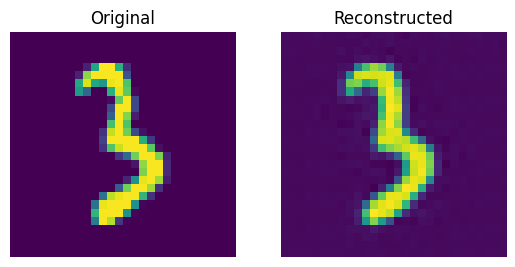

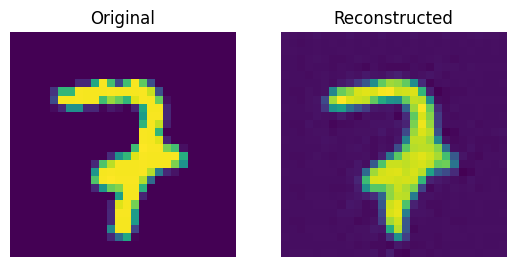

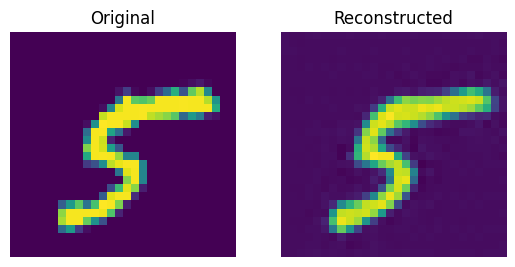

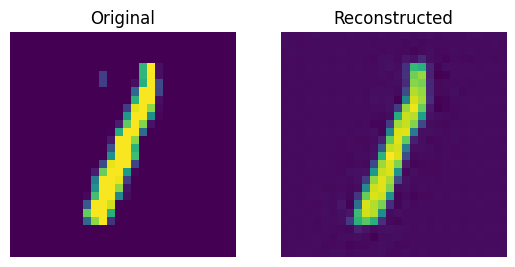

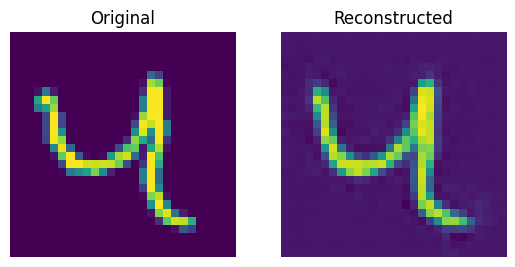

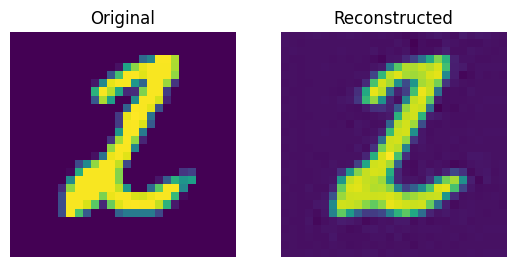

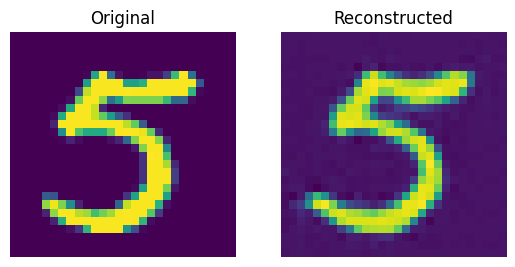

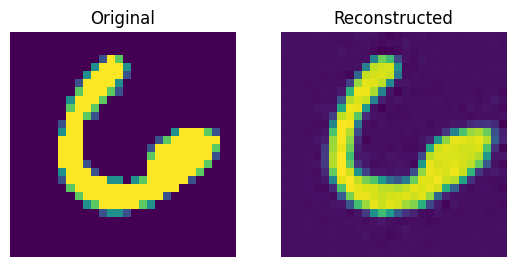

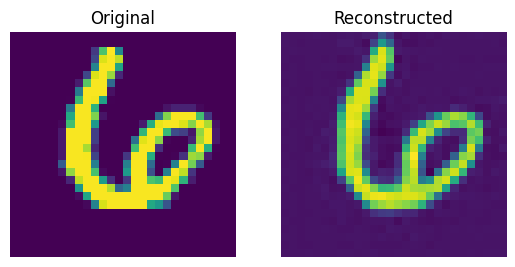

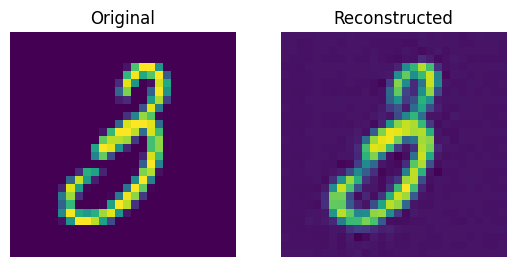

In [60]:
# Reconstruction results on the test set

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

1/1 [==============================] - 0s 23ms/step


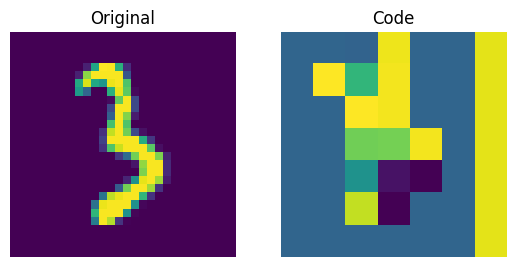

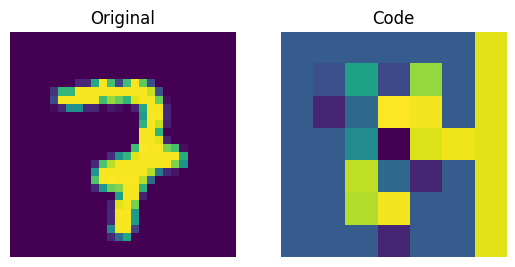

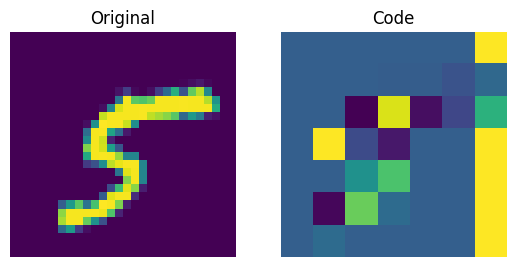

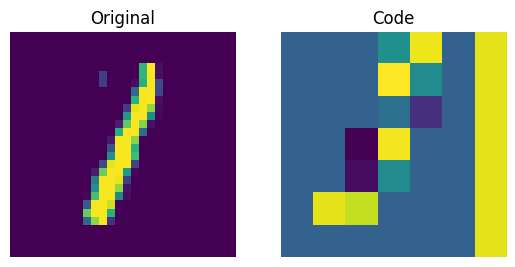

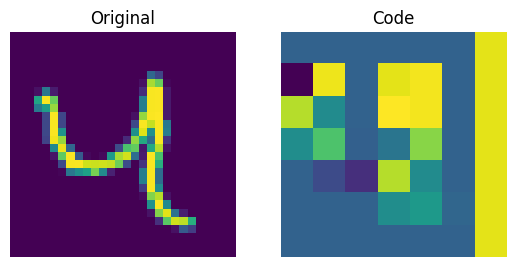

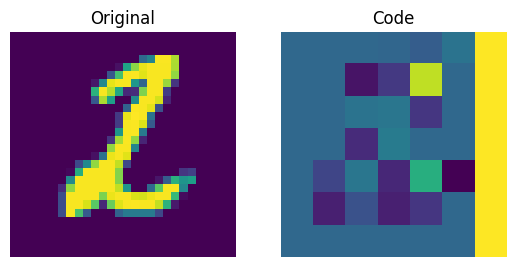

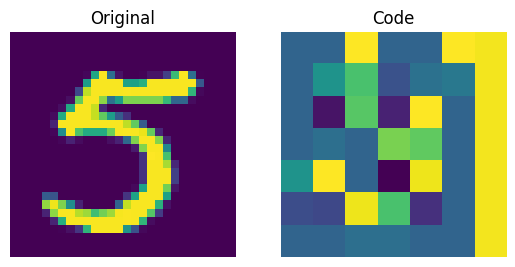

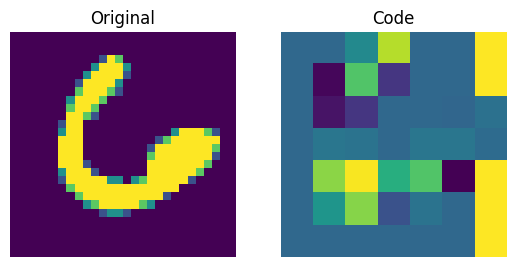

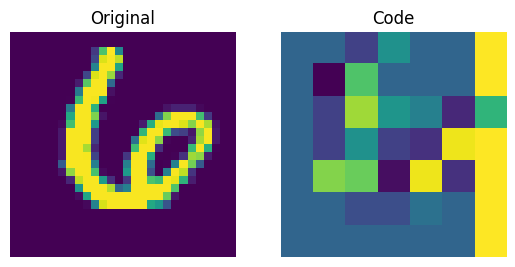

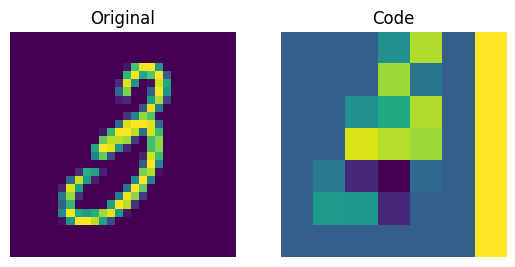

In [61]:
# Visualizing the discrete codes

encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [62]:
print(codebook_indices)

[[[ 45  45  44 123  45  45 121]
  [ 45 126  85 124  45  45 121]
  [ 45  45 126 124  45  45 121]
  [ 45  45 100 101 124  45 121]
  [ 45  45  67  12   6  45 121]
  [ 45  45 115   6  45  45 121]
  [ 45  45  45  45  45  45 121]]

 [[ 45  45  45  45  45  45 121]
  [ 45  40  78  37 108  45 121]
  [ 45  24  50 126 124  45 121]
  [ 45  45  67  12 120 123 121]
  [ 45  45 115  51  24  45 121]
  [ 45  45 113 124  45  45 121]
  [ 45  45  45  24  45  45 121]]

 [[ 45  45  45  45  45  45 121]
  [ 45  45  45  44  44  40  49]
  [ 45  45  12 115  16  35  82]
  [ 45 121  37  19  45  45 121]
  [ 45  45  67  90  45  45 121]
  [ 45  14  96  50  45  45 121]
  [ 45  50  45  45  45  45 121]]

 [[ 45  45  45  67 123  45 121]
  [ 45  45  45 126  65  45 121]
  [ 45  45  45  51  24  45 121]
  [ 45  45   8 124  45  45 121]
  [ 45  45  12  65  45  45 121]
  [ 45 121 115  45  45  45 121]
  [ 45  45  45  45  45  45 121]]

 [[ 45  45  45  45  45  45 121]
  [  8 123  45 121 124  45 121]
  [113  65  45 126 124  45 121]


# Pixel CNN

In [14]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)
